# CoexpressDeconvolve

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
a = time.time()

In [2]:
def ReadVisium(path):
    from scipy.io import mmread
    Barcodes = pd.read_csv(f"{path}/filtered_feature_bc_matrix/barcodes.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Barcodes = Barcodes.iloc[:, 0]
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy import sparse
    Matrix = Matrix.transpose()
    Visium = pd.DataFrame.sparse.from_spmatrix(Matrix, columns=Features)
    Visium.set_index(Barcodes, inplace=True)
    Visium.index.names = ['Barcodes']
    return Visium

def ReadPositionsVisiumSD(path):
    Positions = pd.read_csv(f"{path}/spatial/tissue_positions.csv")
    Positions.set_index("barcode", inplace = True)
    Positions.index.names = ['Barcodes']
    return Positions

def DeconvolveCellTypes(Visium, df_clusters):

    cluster_sums = []

    for idx, gene_list in df_clusters.iloc[:, 0].items():
        # Filter for genes present in the expression data
        valid_genes = [gene for gene in gene_list if gene in Visium.index]
        # Sum expression values for these genes
        cluster_sum = Visium.loc[valid_genes].sum(axis=0)
        # Append result as a new row
        cluster_sums.append(cluster_sum)

    # Convert to DataFrame
    cluster_sum_df = pd.DataFrame(cluster_sums, index=df_clusters.index, columns=Visium.columns)
    return cluster_sum_df

def fit_negative_binomial(data):
    mean_val = np.mean(data)
    var_val = np.var(data)
    
    if var_val > mean_val: 
        r_est = mean_val ** 2 / (var_val - mean_val) 
        p_est = mean_val / var_val  
    else:
        r_est, p_est = np.nan, np.nan 
    
    return r_est, p_est

def VisiumUMISumPerGene(path):
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    from scipy.io import mmread
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy.sparse import csr_matrix
    sdf = csr_matrix(Matrix, dtype='int8')
    UMI_sum = pd.DataFrame(sdf.sum(axis=1))
    UMI_sum.set_index(Features, inplace=True)
    UMI_sum.index.names = ['Features']
    UMI_sum.rename(columns={0:'Feature Counts in Spots Under Tissue'}, inplace=True)
    return UMI_sum

In [3]:
tissue_positions_data = ReadPositionsVisiumSD(".")

# Rotate Image
# Swap x and y
tissue_positions_data = tissue_positions_data.rename(columns={'pxl_row_in_fullres': 'pxl_col_in_fullres', 'pxl_col_in_fullres': 'pxl_row_in_fullres'})

# 1st mirror
# tissue_positions_data['pxl_col_in_fullres'] = -(tissue_positions_data['pxl_col_in_fullres']-tissue_positions_data['pxl_col_in_fullres'].max()) 
# 2nd mirror
tissue_positions_data['pxl_row_in_fullres'] = -(tissue_positions_data['pxl_row_in_fullres']-tissue_positions_data['pxl_row_in_fullres'].max()) 
tissue_positions_data.head()

,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres
Barcodes,,,,,
ACGCCTGACACGCGCT-1,0,0,0,1010,8765
TACCGATCCAACACTT-1,0,1,1,1130,8695
ATTAAAGCGGACGAGC-1,0,0,2,1010,8627
GATAAGGGACGATTAG-1,0,1,3,1130,8558
GTGCAAATCACCAATA-1,0,0,4,1010,8489


In [4]:
Visium = ReadVisium(".")
Visium.rename_axis("Gene", axis=1,inplace=True)
Visium = Visium.T
Visium

Barcodes,AAACAAGTATCTCCCA-1,AAACAATCTACTAGCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACAGTGTTCCTGGG-1,AAACATTTCCCGGATT-1,AAACCCGAACGAAATC-1,AAACCGGGTAGGTACC-1,...,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGGCAATGACTG-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTATTACACG-1,TTGTTTGTGTAAATTC-1
Gene,,,,,,,,,,,,,,,,,,,,,
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL627309.1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AL627309.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC023491.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Make sure to trim the genes with the low expression! This usually results in the 8-10K genes retained

Metrics = VisiumUMISumPerGene('.')

Metrics = Metrics[~Metrics.index.str.startswith(('MT-', 
                                                 # 'LINC',
                                                 # 'MIR', 
                                                 'RP'))]
Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] < 1000].index, inplace=True)
# Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] > 50000].index, inplace=True)

Metrics

,Feature Counts in Spots Under Tissue
Features,
NOC2L,4842
KLHL17,1999
HES4,2103
ISG15,9278
C1orf159,1409
...,...
CMC4,1749
BRCC3,1727
VBP1,3539


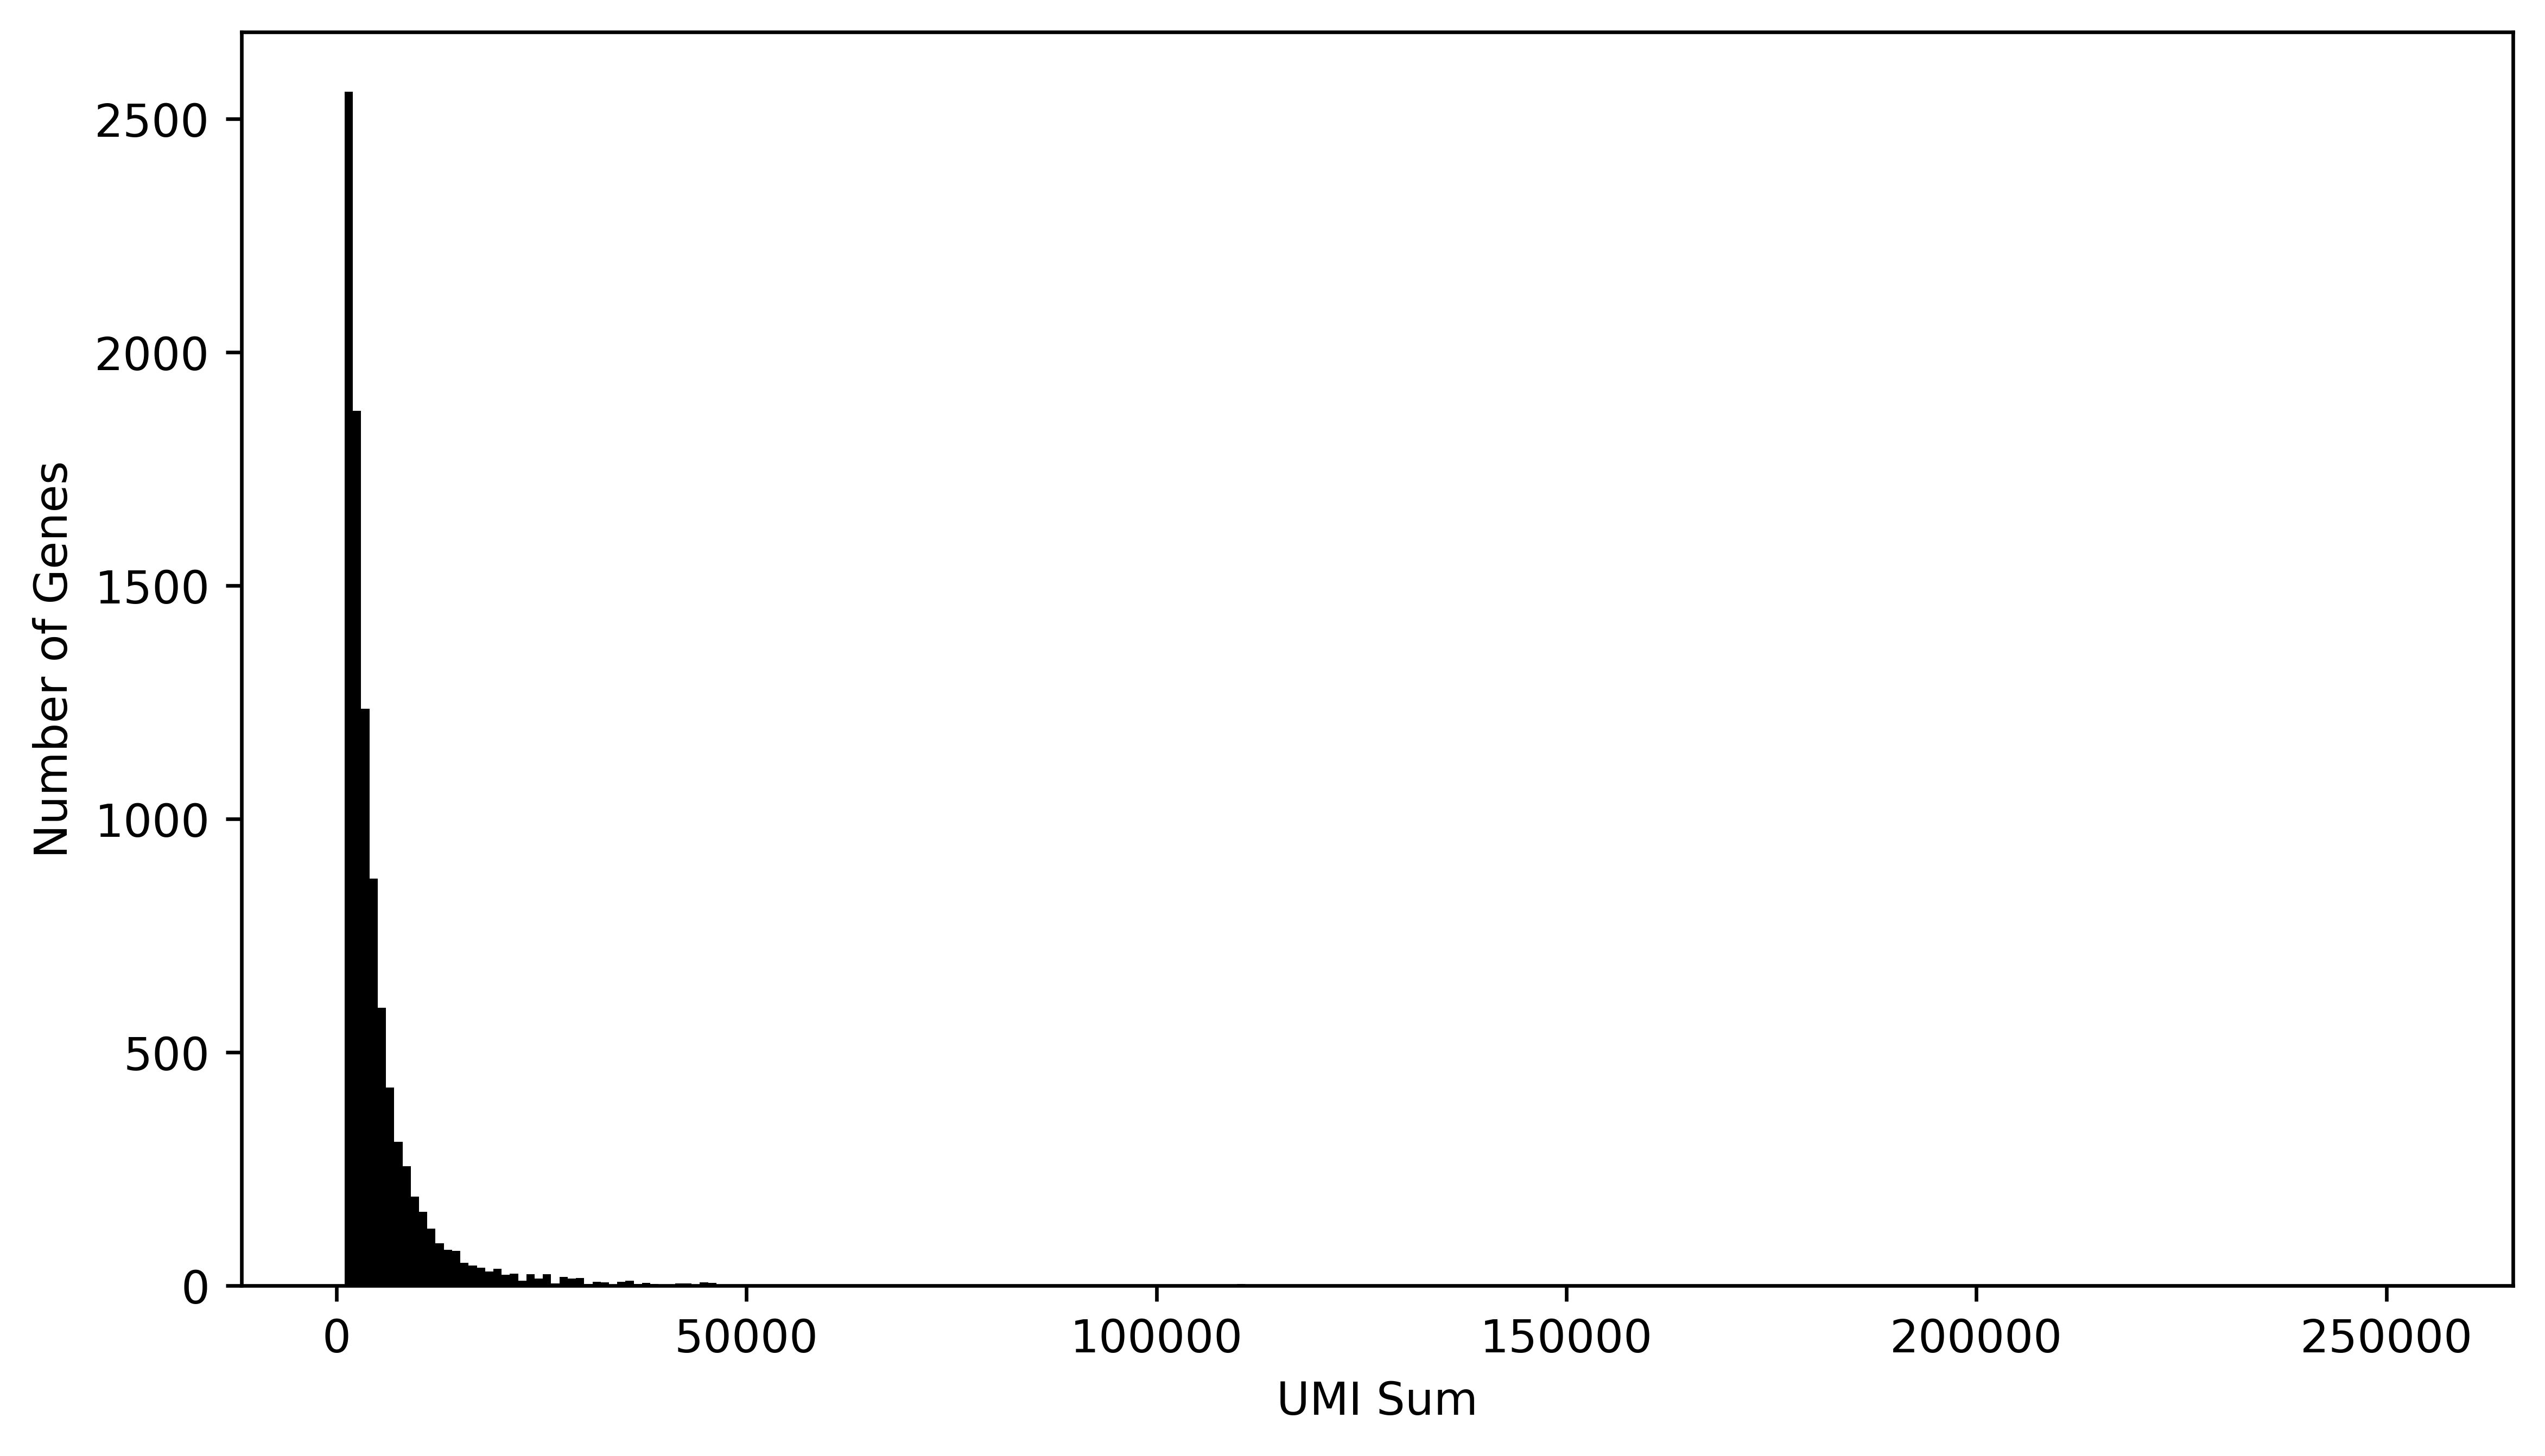

In [6]:
plt.figure(figsize=(9,5), dpi=600)
n_bins = 250
plt.hist(Metrics['Feature Counts in Spots Under Tissue'], n_bins, color='black')
plt.xlabel('UMI Sum')
plt.ylabel('Number of Genes')
plt.show()

In [7]:
# Replace non 0 with 1 to get rid of the GEX levels
Visium_Corr = Visium.where(Visium == 0, 1)
# Visium_Corr = Visium
Visium_Corr = Visium_Corr[Visium_Corr.index.isin(Metrics.index)]
Visium_Corr = Visium_Corr.T
Visium_Corr.head()

Gene,NOC2L,KLHL17,HES4,ISG15,C1orf159,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,...,GAB3,DKC1,MPP1,F8A1,FUNDC2,CMC4,BRCC3,VBP1,CLIC2,VAMP7
Barcodes,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,1,0,0,1,0,0,1,1,1,1,...,1,0,0,0,1,0,1,1,0,1
AAACAATCTACTAGCA-1,1,1,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0,1,1,0,1
AAACACCAATAACTGC-1,1,1,1,1,0,0,1,1,0,1,...,1,1,0,0,1,0,0,1,1,0
AAACAGAGCGACTCCT-1,1,1,0,1,1,0,1,1,0,1,...,0,1,1,1,1,0,1,0,0,0
AAACAGCTTTCAGAAG-1,0,0,0,1,0,1,0,1,1,1,...,1,0,0,0,1,0,0,1,0,0


In [8]:
# Perform gene corr analysis

corr_df = Visium_Corr
corr_df.rename_axis("Gene", inplace=True)
corr_df.rename_axis("Gene", axis=1,inplace=True)

correlation_matrix = corr_df.corr(method='pearson') # pearson / spearman 

correlation_matrix

Gene,NOC2L,KLHL17,HES4,ISG15,C1orf159,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,...,GAB3,DKC1,MPP1,F8A1,FUNDC2,CMC4,BRCC3,VBP1,CLIC2,VAMP7
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,1.000000,0.039059,0.064125,0.085536,0.032543,0.053128,0.080527,0.105804,0.070263,0.065170,...,0.023992,0.117812,0.042206,0.065514,0.056713,0.046081,0.051266,0.065410,0.048249,0.055805
KLHL17,0.039059,1.000000,0.034452,0.073170,0.064517,0.055389,0.085402,0.052312,0.064231,0.088252,...,0.057923,0.042127,-0.005631,0.042312,0.080977,0.027545,0.041006,0.081599,0.018597,0.048175
HES4,0.064125,0.034452,1.000000,0.064731,0.031489,0.067592,0.075304,0.061498,0.010021,0.056321,...,0.045619,0.043770,0.031516,0.031799,0.052949,0.031097,0.030757,0.039650,0.068605,-0.005020
ISG15,0.085536,0.073170,0.064731,1.000000,0.039901,0.105834,0.114797,0.131331,0.087002,0.097254,...,0.067345,0.117991,0.043351,0.028493,0.088183,0.033680,0.060183,0.101600,0.043766,0.084447
C1orf159,0.032543,0.064517,0.031489,0.039901,1.000000,0.027024,0.043262,0.042559,0.013821,0.059488,...,0.015733,0.063255,0.013930,0.007938,0.047620,0.022284,0.035257,0.029185,0.031100,0.033818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC4,0.046081,0.027545,0.031097,0.033680,0.022284,0.039277,0.044125,0.046215,0.033613,0.043785,...,0.043313,0.042534,0.008875,0.072147,0.068765,1.000000,0.055126,0.049421,0.078455,0.037097
BRCC3,0.051266,0.041006,0.030757,0.060183,0.035257,0.030791,0.041858,0.084330,0.019261,0.065172,...,0.036243,0.058336,0.029265,0.027317,0.052333,0.055126,1.000000,0.062650,0.048926,0.033420
VBP1,0.065410,0.081599,0.039650,0.101600,0.029185,0.046255,0.060745,0.053259,0.051476,0.059236,...,0.038902,0.082456,0.052404,0.053446,0.061942,0.049421,0.062650,1.000000,0.058449,0.058704


In [9]:
# Choose a threshold (something around 1.5)
threshold = 1.5

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

distance_matrix = 1 - correlation_matrix.abs()

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Create a dictionary mapping clusters to feature lists
cluster_dict = {}
variables = correlation_matrix.columns

for var, cluster in zip(variables, clusters):
    cluster_dict.setdefault(cluster, []).append(var)

# Remove clusters if needed
filtered_clusters = {k: v for k, v in cluster_dict.items() if len(v) >= 0}

# Convert to DataFrame
df_clusters = pd.DataFrame({'Cluster': list(filtered_clusters.keys()), 'Genes': list(filtered_clusters.values())})
df_clusters.set_index('Cluster', inplace=True)

df_clusters.to_excel('Distance Clusters.xlsx')
df_clusters

,Genes
Cluster,
25,"[NOC2L, C1orf159, B3GALT6, CPTP, MXRA8, MMP23B..."
27,"[KLHL17, DVL1, PEX14, IFFO2, LUZP1, MECR, FAM2..."
21,"[HES4, PRKCZ, MEGF6, FBXO6, AGTRAP, NBL1, SELE..."
11,"[ISG15, UBE2J2, AURKAIP1, SSU72, RER1, LRRC47,..."
24,"[TNFRSF18, ACAP3, ATAD3A, SKI, PANK4, TPRG1L, ..."
6,"[TNFRSF4, MRPL20-AS1, ATAD3B, MIB2, PLCH2, ZBT..."
2,"[SDF4, MRPL20, GNB1, PIK3CD, TNFRSF1B, HP1BP3,..."
22,"[PUSL1, ANKRD65, VWA1, PRXL2B, CEP104, ACOT7, ..."
8,"[INTS11, NADK, FAAP20, RERE, SLC2A5, VPS13D, E..."


In [10]:
Visium = Visium[Visium.index.isin(Metrics.index)]
Visium = Visium[~Visium.index.duplicated(keep="first")]
Visium

Barcodes,AAACAAGTATCTCCCA-1,AAACAATCTACTAGCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACAGTGTTCCTGGG-1,AAACATTTCCCGGATT-1,AAACCCGAACGAAATC-1,AAACCGGGTAGGTACC-1,...,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGGCAATGACTG-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTATTACACG-1,TTGTTTGTGTAAATTC-1
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,5,2,2,4,0,3,1,0,4,1,...,1,0,0,1,2,0,3,1,1,3
KLHL17,0,1,2,1,0,1,1,1,1,0,...,1,1,0,2,0,0,0,0,0,0
HES4,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
ISG15,1,0,2,52,6,1,3,1,3,1,...,0,1,0,3,1,2,1,1,0,6
C1orf159,0,0,0,1,0,1,1,0,1,2,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC4,0,0,0,0,0,2,2,0,1,0,...,0,0,0,0,0,2,0,1,0,1
BRCC3,2,1,0,1,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
VBP1,3,1,2,0,1,1,0,4,4,0,...,0,1,1,2,2,0,0,0,1,0


In [11]:
deconvolution = DeconvolveCellTypes(Visium, df_clusters)
deconvolution

Barcodes,AAACAAGTATCTCCCA-1,AAACAATCTACTAGCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACAGTGTTCCTGGG-1,AAACATTTCCCGGATT-1,AAACCCGAACGAAATC-1,AAACCGGGTAGGTACC-1,...,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGGCAATGACTG-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1,TTGTTTGTATTACACG-1,TTGTTTGTGTAAATTC-1
Cluster,,,,,,,,,,,,,,,,,,,,,
25,572,595,939,684,614,771,568,401,718,546,...,285,596,303,462,381,432,507,540,320,728
27,132,158,182,154,91,167,137,87,149,125,...,76,144,67,87,74,73,105,115,88,168
21,293,245,592,350,293,317,319,224,380,326,...,174,265,139,205,163,249,277,329,156,288
11,1174,1344,1986,1621,1354,1610,1206,913,1484,1051,...,626,1273,658,923,844,875,1019,1016,684,1481
24,1061,1180,1802,1275,1163,1479,1054,853,1344,924,...,549,1085,574,811,730,800,938,992,513,1272
6,1141,1199,1951,1494,1256,1556,1219,826,1536,1048,...,605,1245,667,909,750,850,912,1038,510,1476
2,1525,1585,2708,2039,1683,2034,1649,1216,2033,1410,...,754,1543,827,1176,1027,1218,1396,1466,775,1924
22,845,887,1571,1145,1042,1140,877,707,1173,819,...,484,922,448,722,613,620,783,833,437,999
8,1522,1532,2708,2070,1686,1996,1509,1123,1903,1431,...,742,1557,853,1173,1153,1092,1329,1336,717,1743


In [12]:
df = deconvolution.T

percentile = 0.85 # 0.8 - 0.95 is the recommended range

from scipy.stats import nbinom

# Extract numeric data (excluding Gene column if present)
df_numeric = df.iloc[:, 0:] 

# Fit NB parameters for each feature
nb_params = {col: fit_negative_binomial(df_numeric[col]) for col in df_numeric.columns}
nb_params_df = pd.DataFrame(nb_params, index=["r", "p"]).T

# Compute 90th percentile threshold
thresholds = {col: nbinom.ppf(percentile, nb_params_df.loc[col, "r"], nb_params_df.loc[col, "p"]) 
                 for col in df_numeric.columns}

# Convert to DataFrame
thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

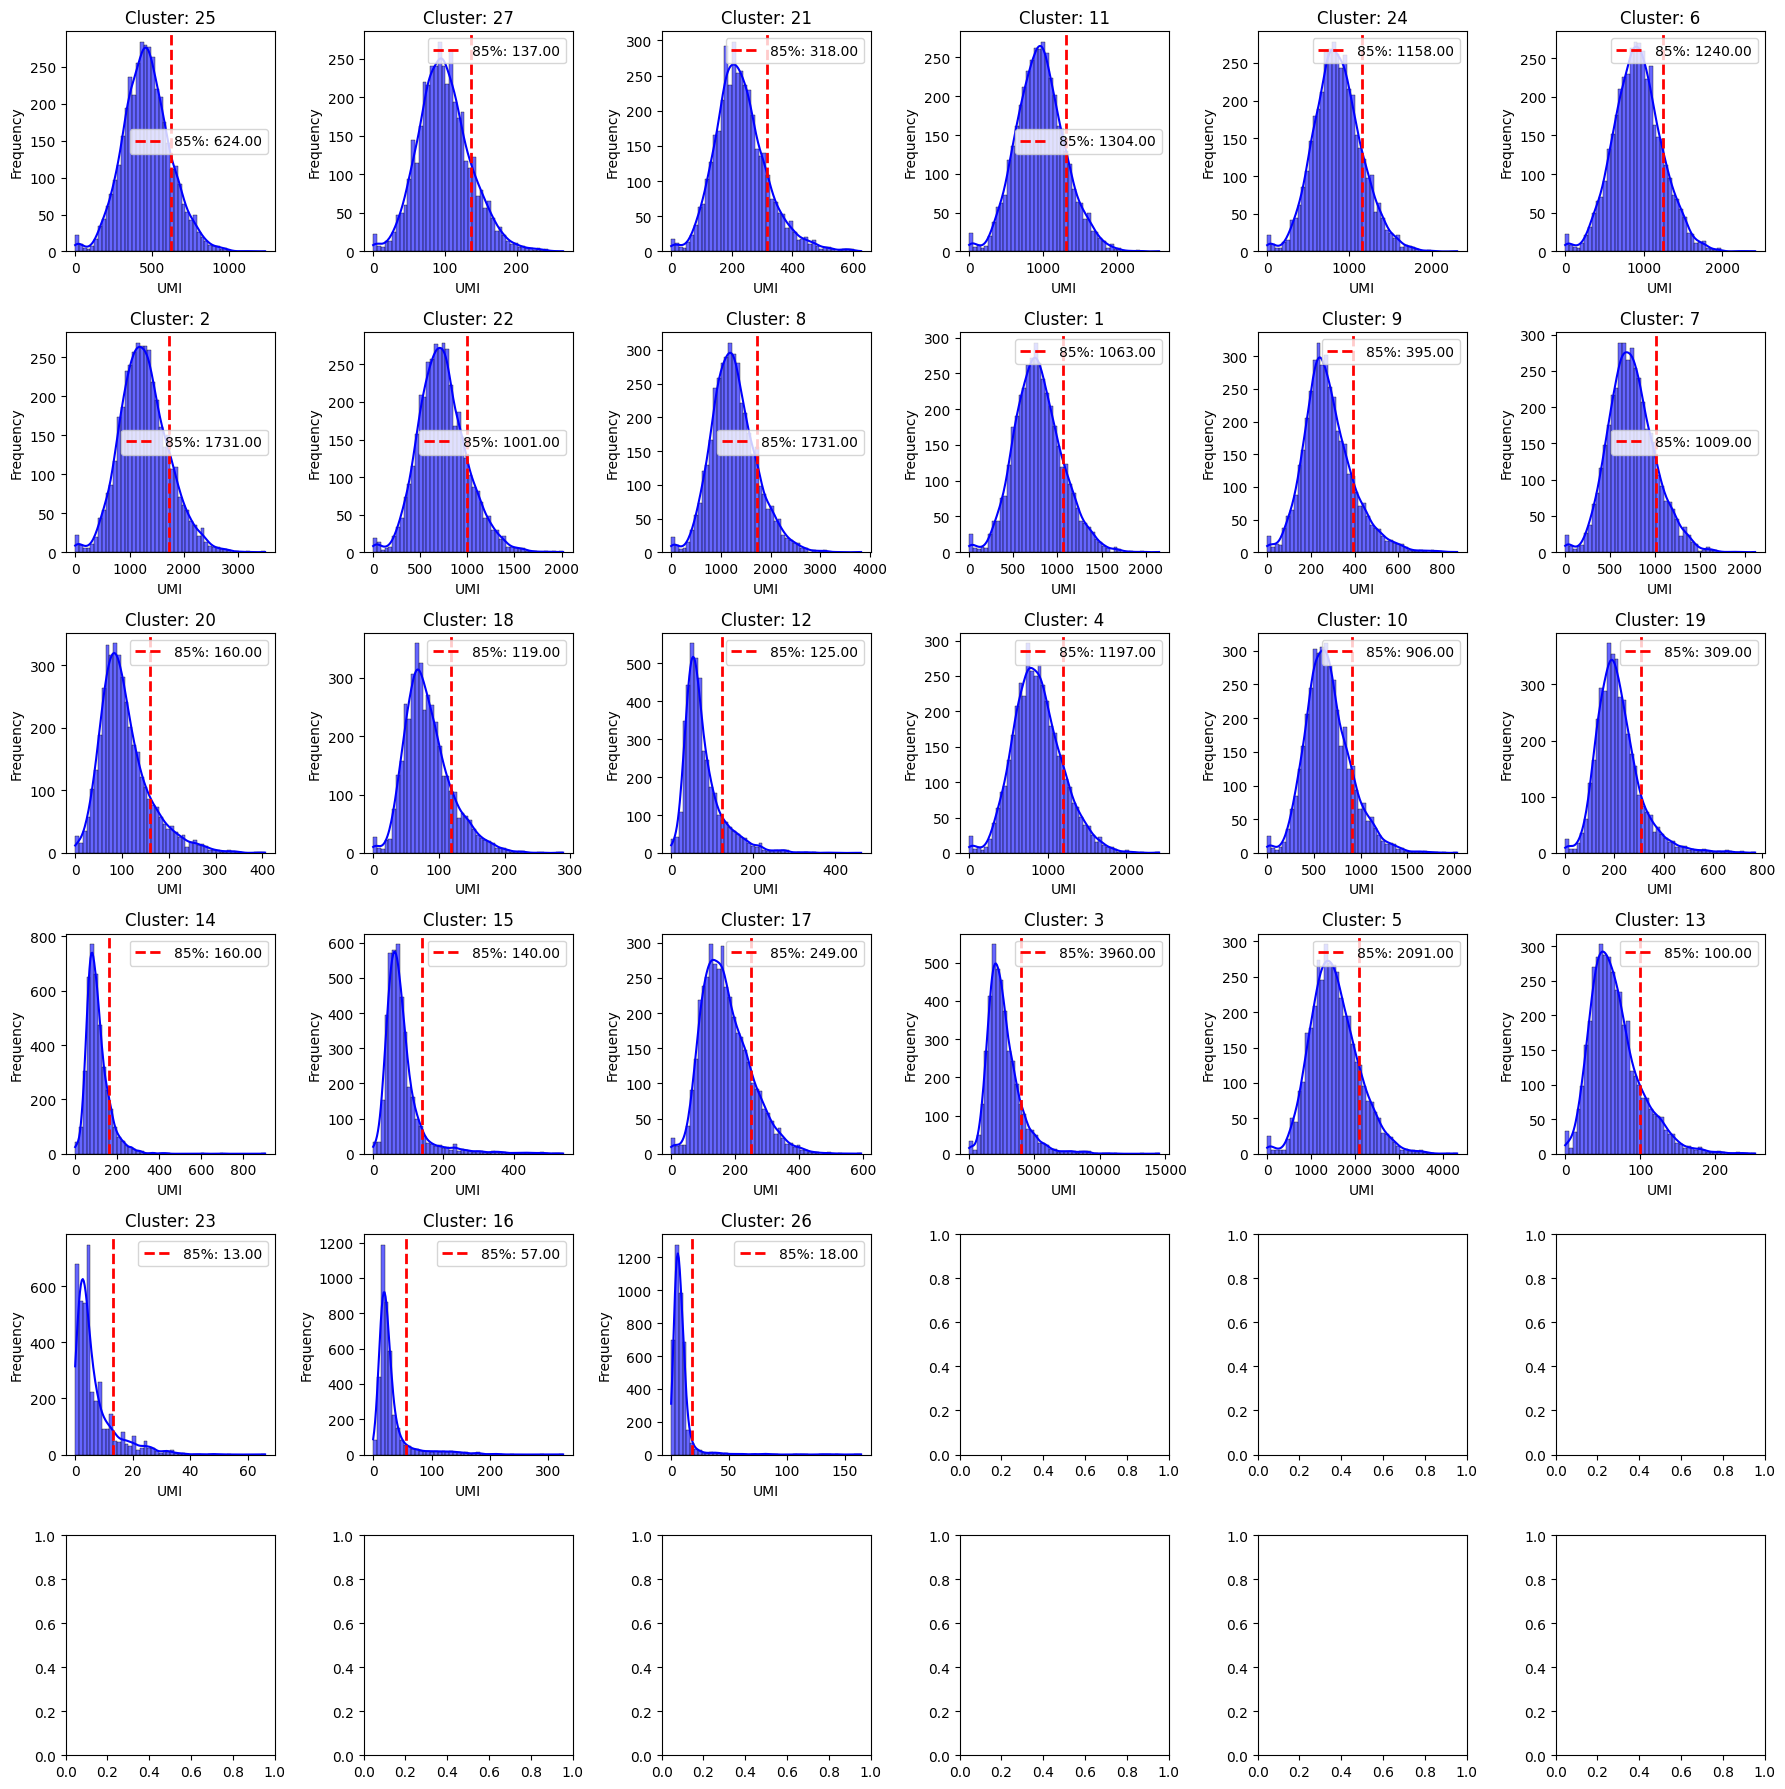

In [13]:
# Plot histograms with percentile threshold lines
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    ax = axes[i]
    sns.histplot(df_numeric[col], bins=50, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
    ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"85%: {thresholds[col]:.2f}")
    ax.set_title(f"Cluster: {col}")
    ax.set_xlabel("UMI")
    ax.set_ylabel("Frequency")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# thresholds_df.T

In [15]:
# # UMI Th should be placed directly afther the main distrubution or inbetween the two in case of a bi-modal distribution

# updated_th = [25.0,57.0,422.0,25.0,11.0,25.0,17.0,9.0,34.0,50.0,75.0,50.0,34.0,120.0,440.0,548.0,210.0,250.0]

# keys = list(thresholds.keys())

# for k, v in zip(keys, updated_th):
#     thresholds[k] = v

# thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

# # Plot histograms with 99th percentile threshold lines
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
# axes = axes.flatten()

# for i, col in enumerate(df_numeric.columns):
#     ax = axes[i]
#     sns.histplot(df_numeric[col], bins=30, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
#     ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"Th: {thresholds[col]:.2f}")
#     ax.set_title(f"Cluster: {col}")
#     ax.set_xlabel("UMI")
#     ax.set_ylabel("Frequency")
#     ax.legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [16]:
# Calculate putative cell count per spot 
# by replacing the values less than the percentile threshold with 0, counting medians, and dividing by them
thresholds_broadcasted = thresholds_df.reindex(deconvolution.index).values 

deconvolution_filtered = deconvolution.where(deconvolution >= thresholds_broadcasted, 0)

deconvolution_nonzero = deconvolution_filtered.replace(0, np.nan)

cluster_medians = deconvolution_nonzero.median(axis=1, numeric_only=True)

cell_count = np.ceil(deconvolution_nonzero.div(cluster_medians, axis=0))

cell_count = cell_count.fillna(0).astype(int)

cell_count.T.sum()

Cluster
25    884
27    912
21    829
11    897
24    900
6     899
2     906
22    887
8     867
1     916
9     854
7     888
20    849
18    907
12    825
4     898
10    877
19    754
14    783
15    559
17    931
3     758
5     913
13    913
23    887
16    587
26    406
dtype: int64

In [17]:
cells_per_spot = 6 # Set putative meadian cell per spot count
spots = deconvolution.shape[1]

print(f'                       The predicted total cell number is {spots * cells_per_spot}')
print(f'The total cell number observed after the deconvolution is {cell_count.T.sum().sum()}')
print(f'                                The ratio is {(spots * cells_per_spot)/(cell_count.T.sum().sum())}')

                       The predicted total cell number is 24210
The total cell number observed after the deconvolution is 22486
                                The ratio is 1.0766699279551721


In [18]:
# Call Putative cell clusters per spot

# Convert Visium and cell_count to dense format
Visium = Visium.astype(float)
cell_count = cell_count.astype(float)

# Create a new DataFrame for subcells
filtered_columns = [
    f"{spot}_{cluster}" for spot in Visium.columns for cluster in df_clusters.index
    if cell_count.at[cluster, spot] > 0  # Only keep clusters with nonzero putative cell counts
]

# Initialize putative_cell_df with only the required columns
putative_cell_df = pd.DataFrame(0, index=Visium.index, columns=filtered_columns, dtype=float)

# Populate putative_cell_df with gene expression values
for spot in Visium.columns:
    for cluster, genes in df_clusters["Genes"].items():
        if cell_count.at[cluster, spot] > 0:  # Check if putative cell count is above 0
            subspot_name = f"{spot}_{cluster}"  
            putative_cell_df[subspot_name] = Visium[spot]  # Copy UMI cell values
            putative_cell_df.loc[~putative_cell_df.index.isin(genes), subspot_name] = 0  # Set non-cluster genes to 0

putative_cell_per_spot = putative_cell_df.astype(int)

putative_cell_per_spot

,AAACAAGTATCTCCCA-1_3,AAACAAGTATCTCCCA-1_5,AAACAAGTATCTCCCA-1_13,AAACAAGTATCTCCCA-1_23,AAACAATCTACTAGCA-1_27,AAACAATCTACTAGCA-1_11,AAACAATCTACTAGCA-1_24,AAACAATCTACTAGCA-1_20,AAACAATCTACTAGCA-1_23,AAACACCAATAACTGC-1_25,...,TTGTTTGTGTAAATTC-1_11,TTGTTTGTGTAAATTC-1_24,TTGTTTGTGTAAATTC-1_6,TTGTTTGTGTAAATTC-1_2,TTGTTTGTGTAAATTC-1_8,TTGTTTGTGTAAATTC-1_7,TTGTTTGTGTAAATTC-1_20,TTGTTTGTGTAAATTC-1_4,TTGTTTGTGTAAATTC-1_5,TTGTTTGTGTAAATTC-1_23
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
KLHL17,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ISG15,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
C1orf159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
BRCC3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VBP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Call Putative cells per spot

cell_count.index = cell_count.index.astype(str)
cell_count.columns = cell_count.columns.astype(str)

# Initialize a new DataFrame for putative_cells
putative_cell_data = {}

# Iterate through each subcell in putative_cell_per_spot
for subcell in putative_cell_per_spot.columns:
    cell, cluster = map(str, subcell.split("_"))  # Ensure names are strings
    
    # Check if cluster and cell exist in cell_count before accessing
    if cluster in cell_count.index and cell in cell_count.columns:
        putative_count = cell_count.at[cluster, cell]
    else:
        print(f"Warning: Skipping {subcell} - No match found in cell_count")
        continue  # Skip this subcell if the match isn't found

    if putative_count > 0:  # Only process if there are putative_cells
        putative_count = int(np.ceil(putative_count))  # Ensure it's an integer
        split_values = np.ceil(putative_cell_per_spot[subcell] / putative_count).astype(int)
    
        # Create new columns for each putative_cell
        for i in range(1, putative_count + 1):  # Now `putative_count` is an integer
            putative_cell_name = f"{subcell}_{i}"
            putative_cell_data[putative_cell_name] = split_values

# Convert to DataFrame
putative_cell_df = pd.DataFrame(putative_cell_data)

putative_cell_df = putative_cell_df.loc[:, putative_cell_df.sum(axis=0) != 0]

putative_cell_df = putative_cell_df.astype(str)

putative_cell_df = putative_cell_df[~putative_cell_df.index.duplicated(keep="first")]

putative_cell_df

,AAACAAGTATCTCCCA-1_3_1,AAACAAGTATCTCCCA-1_3_2,AAACAAGTATCTCCCA-1_5_1,AAACAAGTATCTCCCA-1_13_1,AAACAAGTATCTCCCA-1_23_1,AAACAAGTATCTCCCA-1_23_2,AAACAATCTACTAGCA-1_27_1,AAACAATCTACTAGCA-1_27_2,AAACAATCTACTAGCA-1_11_1,AAACAATCTACTAGCA-1_24_1,...,TTGTTTGTGTAAATTC-1_6_2,TTGTTTGTGTAAATTC-1_2_1,TTGTTTGTGTAAATTC-1_8_1,TTGTTTGTGTAAATTC-1_7_1,TTGTTTGTGTAAATTC-1_20_1,TTGTTTGTGTAAATTC-1_20_2,TTGTTTGTGTAAATTC-1_4_1,TTGTTTGTGTAAATTC-1_5_1,TTGTTTGTGTAAATTC-1_23_1,TTGTTTGTGTAAATTC-1_23_2
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KLHL17,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ISG15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1orf159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRCC3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VBP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import json
import math

# Load the JSON file
with open("./spatial/scalefactors_json.json", "r") as file:
    scalefactors = json.load(file)

# Extract and round up the spot radius
SPOT_RADIUS = math.ceil(scalefactors["spot_diameter_fullres"])
SPOT_RADIUS

90

In [21]:
# Randomly allocate Putative cells within their spot

# Spot radius and min distance
MIN_DISTANCE = SPOT_RADIUS/15*6 # Minimum pixel separation between putative_cells

# Initialize spatial coordinates dictionary
putative_cell_spatial = {}

# Iterate over putative_cells and assign random spatial positions
for putative_cell in putative_cell_df.columns:
    # Extract the correct `cell_cluster` name
    cell_cluster = putative_cell.split("_", 1)[0]  # Keep only barcode (remove extra numbers)

    if cell_cluster in tissue_positions_data.index:
        center_x = tissue_positions_data.at[cell_cluster, "pxl_row_in_fullres"]
        center_y = tissue_positions_data.at[cell_cluster, "pxl_col_in_fullres"]
    else:
        print(f"Warning: {cell_cluster} not found in tissue_positions_data")
        continue  # Skip if no spatial data

    # Generate unique positions within spot radius
    putative_cell_positions = []
    attempts = 0
    
    while len(putative_cell_positions) < 1:  # Only need one valid position per putative_cell
        # Randomly place within the spot's circular area
        rand_radius = np.random.uniform(0, SPOT_RADIUS)
        rand_angle = np.random.uniform(0, 2 * np.pi)
        new_x = center_x + rand_radius * np.cos(rand_angle)
        new_y = center_y + rand_radius * np.sin(rand_angle)
        
        # Ensure at least MIN_DISTANCE separation from other putative_cells
        if all(np.sqrt((new_x - x)**2 + (new_y - y)**2) >= MIN_DISTANCE for x, y in putative_cell_positions):
            putative_cell_positions.append((new_x, new_y))
            putative_cell_spatial[putative_cell] = (new_x, new_y)
        else:
            attempts += 1
            if attempts > 100:  # Prevent infinite loops
                print(f"Warning: Could not place {putative_cell} with required spacing")
                break

# Convert to mimic the Vizgen format
putative_cell_spatial_df = pd.DataFrame.from_dict(putative_cell_spatial, orient="index", columns=["center_x", "center_y"])
putative_cell_spatial_df['z'] = 0
putative_cell_spatial_df['fov'] = 0

# Export data in Vizgen format
putative_cell_df.astype(int).T.to_csv('cell_by_gene.csv') 
putative_cell_spatial_df.to_csv('cell_metadata.csv')

putative_cell_spatial_df

,center_x,center_y,z,fov
AAACAAGTATCTCCCA-1_3_1,1751.113679,7034.331784,0,0
AAACAAGTATCTCCCA-1_3_2,1745.205850,6997.554961,0,0
AAACAAGTATCTCCCA-1_5_1,1719.160670,7060.097283,0,0
AAACAAGTATCTCCCA-1_13_1,1735.877936,6989.920940,0,0
AAACAAGTATCTCCCA-1_23_1,1713.259870,6997.587693,0,0
...,...,...,...,...
TTGTTTGTGTAAATTC-1_20_2,5267.011021,1843.450645,0,0
TTGTTTGTGTAAATTC-1_4_1,5230.935918,1832.538609,0,0
TTGTTTGTGTAAATTC-1_5_1,5174.544468,1825.131276,0,0
TTGTTTGTGTAAATTC-1_23_1,5306.944657,1797.942877,0,0


In [22]:
# Export Cluster numbers
cluster_df = putative_cell_spatial_df.index.str.extract(r'-1_(\d+)_')
cluster_df = cluster_df.rename(columns={0: 'Cluster'})
cluster_df.index = putative_cell_spatial_df.index
cluster_df.to_csv('cluster_info.csv')
cluster_df.head()
b = time.time()

In [23]:
print(f'It took {(b - a)/60} minutes')

It took 10.708250765005747 minutes
